# CONNECTED-COMPONENT LABELING
- Also known as connected component analysis, blob extraction or region labeling
- Application of graph theory that is used to determine connectivity of blob-like regions in binary image
- Often used in same situations as contours. But this gives more granular filtering of blobs, as during contour analysis we are restricted by hierarchy of outlines (one contour within another).

## The Classical Approach
- Applied only to binary or thresholded images.
- Consists of two passes.
 
### First Pass
- Algorithm loops over each pixel and inspects the west/north pixel of current pixels' immediate neighborhood
- Based on the N/W pixels, label is assigned to current pixel
- We inspect only north/west pixel because the algo is a recursive process. By repeating the process over the entire image, one row at a time, each pixel will actually be checked for 4-connectivity

### Step 1
- First step is to check if center pixel is bg or fg.
- If bg pixel (usually pixel value 0), then ignore and move to next pixel
- If fg pixel (pixel value non-zero), then go to step 2-3

### Step 2 & 3
- Current pixel is fg pixel for sure at this stage, so inspect N/W pixel.
    - Both N/W are bg pixels, so no labels associated with them. In this case create new label (normally by incrementing a unique label counter) and store the label value in current pixel. Move on to Step 4 & 5
    - N and/or W are not bg pixels. So we proceed to Step 4 & 5
    
### Steps 4 and 5
- Set the label of current p pixel by taking min of label value: <br>
$p=min(N,W)$

### Step 6
- If two regions of different labels are connected, we leverage union 

## Second Pass
- The algo loops over the labels generated from first pass and merges any regions together that share connected labels.
- We can connect blobs with different label values but that are actually part of the same blob. The key to efficiency is to use the union-find data structure for tree-traversal when examining label values.

In [1]:
import sys
sys.path.append("../")

In [2]:
from skimage.filters import threshold_local
from skimage import measure
import numpy as np
import cv2
from cv_imshow import create_subplot, display_image
from matplotlib import pyplot as plt

In [3]:
args = {
    "image": "../images/license_plate.png"
}

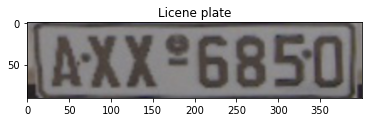

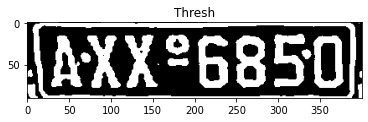

In [4]:
plate = cv2.imread(args["image"])

#extract value component from HSV and apply adaptive thresh
V = cv2.split(cv2.cvtColor(plate, cv2.COLOR_BGR2HSV))[2]
thresh = cv2.adaptiveThreshold(V, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                              cv2.THRESH_BINARY_INV, 17, 3)

display_image("Licene plate", plate)
display_image("Thresh", thresh)

In [5]:
# perform connected component analysis on thresh image and init mask to hold only large components we are interested in
labels = measure.label(thresh, connectivity=2, background=0)
mask = np.zeros(thresh.shape, dtype="uint8")
print("[INFO] found {} blobs".format(len(np.unique(labels))))

[INFO] found 19 blobs


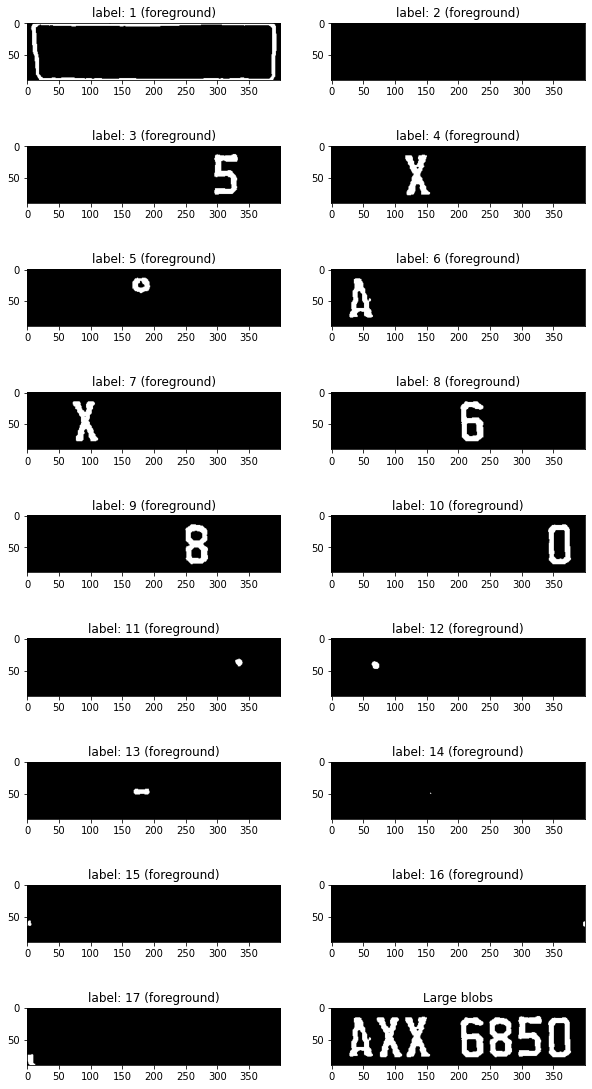

In [6]:
fig = plt.figure(figsize=(10,20))
rows = 9
columns = 2
for (i, label) in enumerate(np.unique(labels)):
    #if background label, ignore
    if label==0:
        continue
    
    #otherwise construct mask to display only connected components for current label
    #print("[INFO] label: {} (foreground)".format(i))
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
    
    
    #eliminate very small blobs and very large blobs by adding only blobs that meet below condition
    if numPixels > 1000 and numPixels < 1500:
        mask = cv2.add(mask, labelMask)
    
    #show the label mask
    create_subplot(fig, rows, columns, label,
                   "label: {} (foreground)".format(i), labelMask)

display_image("Large blobs", mask)